In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as stats 
import seaborn as sns
import os
import re

# For Text processing
from wordcloud import WordCloud, STOPWORDS  
from bs4 import BeautifulSoup as bfs  # used to read in website data
import nltk 
# Lemmatizer reduces words into their root form: wolves -> wolf, jumping -> jump, etc. 
from nltk.stem import WordNetLemmatizer as WNL    
from nltk.corpus import wordnet 
from nltk import pos_tag
from nltk.corpus import stopwords

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
df1 = pd.read_csv('live.csv')
df2 = pd.read_csv('most_backed.csv')

### Feature Comparison and Overview 
__Most Backed__ (df2) has more data on the pledge and backing tiers. <br> 
<font color=pink>__Live__ (df1)</font> has end_time, url, and percentage funded, which aren't as useful.  <br> 
Will examine __Most Backed__ (df2) from this point. 

In [8]:
df1.shape
print("Live columns" )
df1.columns 
print("Most-Backed dataset")
df2.head()
df2.shape

(4000, 13)

Live columns


Index(['Unnamed: 0', 'amt.pledged', 'blurb', 'by', 'country', 'currency',
       'end.time', 'location', 'percentage.funded', 'state', 'title', 'type',
       'url'],
      dtype='object')

Most-Backed dataset


Unnamed: 0  amt.pledged                                              blurb  \
0           0    8782571.0  \nThis is a card game for people who are into ...   
1           1    6465690.0  \nAn unusually addicting, high-quality desk to...   
2           2    5408916.0  \nBring Reading Rainbow’s library of interacti...   
3           3    5702153.0  \nUPDATED: This is it. We're making a Veronica...   
4           4    3336371.0  \nAn adventure game from Tim Schafer, Double F...   

                                     by        category currency       goal  \
0                              Elan Lee  Tabletop Games      usd    10000.0   
1            Matthew and Mark McLachlan  Product Design      usd    15000.0   
2        LeVar Burton & Reading Rainbow             Web      usd  1000000.0   
3                            Rob Thomas  Narrative Film      usd  2000000.0   
4  Double Fine and 2 Player Productions     Video Games      usd   400000.0   

            location  num.backers  \
0    Los Angeles, CA       219382   
1         Denver, CO       154926   
2    Los Angeles, CA       105857   
3      San Diego, CA        91585   
4  San Francisco, CA        87142   

                                    num.backers.tier  \
0                            [15505, 202934, 200, 5]   
1  [788, 250, 43073, 21796, 41727, 21627, 12215, ...   
2  [19639, 14343, 9136, 2259, 5666, 24512, 4957, ...   
3  [5938, 8423, 11509, 22997, 23227, 1865, 7260, ...   
4  [47946, 24636, 1090, 11530, 900, 148, 100, 10, 4]   

                                         pledge.tier  \
0                         [20.0, 35.0, 100.0, 500.0]   
1  [1.0, 14.0, 19.0, 19.0, 35.0, 35.0, 79.0, 79.0...   
2  [5.0, 10.0, 25.0, 30.0, 35.0, 50.0, 75.0, 100....   
3  [1.0, 10.0, 25.0, 35.0, 50.0, 75.0, 100.0, 150...   
4  [15.0, 30.0, 60.0, 100.0, 250.0, 500.0, 1000.0...   

                                               title  \
0                                  Exploding Kittens   
1                      Fidget Cube: A Vinyl Desk Toy   
2  Bring Reading Rainbow Back for Every Child, Ev...   
3                    The Veronica Mars Movie Project   
4                              Double Fine Adventure   

                                                 url  
0                /projects/elanlee/exploding-kittens  
1   /projects/antsylabs/fidget-cube-a-vinyl-desk-toy  
2  /projects/readingrainbow/bring-reading-rainbow...  
3  /projects/559914737/the-veronica-mars-movie-pr...  
4         /projects/doublefine/double-fine-adventure

(4000, 13)

### Exploration of features 
We look at number of unique values for each columns. <br>
<font color='green'> Category, and currency </font> look easy to pivot on and possibly create features. everything else would require some kind of bucketing or normalization. 

In [9]:
df1.columns
df2.columns
print("Unique values") 
df2.nunique(axis=0)   # num of unique values for each column 

Index(['Unnamed: 0', 'amt.pledged', 'blurb', 'by', 'country', 'currency',
       'end.time', 'location', 'percentage.funded', 'state', 'title', 'type',
       'url'],
      dtype='object')

Index(['Unnamed: 0', 'amt.pledged', 'blurb', 'by', 'category', 'currency',
       'goal', 'location', 'num.backers', 'num.backers.tier', 'pledge.tier',
       'title', 'url'],
      dtype='object')

Unique values


Unnamed: 0          4000
amt.pledged         3968
blurb               3975
by                  3137
category             115
currency               9
goal                 348
location             806
num.backers         2361
num.backers.tier    3993
pledge.tier         3973
title               3990
url                 3993
dtype: int64

Exploring Project Creators:
<br> <br> 
Over 3k unique creators, but only 42 with fairyl deep experience (5 or more projects). One creator had 24 projects. 

In [17]:
by_counts = pd.DataFrame(df2.by.value_counts()).reset_index()  
by_counts.by.describe()   # statistics on count by project creator 
by_counts.columns = ['project_creator','count']
print("No. of Creators with 5 or more projects: ", len(by_counts[by_counts['count']>=5]))

count    3137.000000
mean        1.275104
std         1.035343
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        24.000000
Name: by, dtype: float64

No. of Creators with 5 or more projects:  42


Investigating Categories <br> <br> 

Target these categories: <br><br>
<font color=green>'Product Design', 'Apparel', 'Wearables','Small Batch','Shorts', 'Ready-to-wear','Vegan'</font>

In [61]:
# Investigate other categories 
df2.category.unique()

# Investigate these categories: 'Product Design', 'Apparel', 'Wearables','Small Batch','Shorts', 'Ready-to-wear','Vegan'

array(['Tabletop Games', 'Product Design', 'Web', 'Narrative Film',
       'Video Games', 'Technology', 'Gaming Hardware', 'Television',
       'Hardware', 'Music', 'Space Exploration', 'Radio &amp; Podcasts',
       'Flight', 'Sound', 'Animation', 'Games', 'Action', 'Gadgets',
       'Documentary', '3D Printing', 'DIY Electronics', 'Publishing',
       'Fashion', 'Comics', 'Typography', "Children's Books", 'Apparel',
       'Food', 'Crafts', 'Camera Equipment', 'Comedy', 'Design',
       'Graphic Design', 'Apps', 'Hip-Hop', 'World Music',
       'Film &amp; Video', 'Drinks', 'Wearables', 'Accessories',
       'Footwear', 'Science Fiction', 'Art Books', 'Nonfiction', 'Robots',
       'Art', 'Software', 'Chiptune', 'Webseries', 'Webcomics', 'Rock',
       'Playing Cards', 'Cookbooks', 'Fantasy', 'Photography',
       'Anthologies', 'Faith', 'Mixed Media', 'Metal', 'Small Batch',
       'Classical Music', 'Architecture', 'Pop', 'Dance',
       'Electronic Music', 'Graphic Novels', 'Music

In [13]:
# Aggregate: Category level 
cat_valcount = pd.DataFrame(df2.category.value_counts())
cat_valcount.reset_index(level=0, inplace=True)
cat_valcount.columns = ['category','value_count']
cat_valcount.head()
df2['avg_pledge'] = df2["amt.pledged"] / df2['num.backers']    #average pledge per campaign  
    # reset_index turns category into a field (instead of an index). 
avg_pledge_cat = df2.groupby("category").apply(lambda x: np.mean(x['amt.pledged']/x['num.backers'])).reset_index()
avg_pledge_cat.columns=['category','avg_pledge_backer']
avg_pledge_cat.head()

category  value_count
0  Product Design          773
1  Tabletop Games          742
2     Video Games          524
3        Hardware          182
4      Technology          152

category  avg_pledge_backer
0  3D Printing         216.639694
1     Academic          62.610541
2  Accessories          66.062813
3       Action          35.568170
4    Animation          71.048812

In [14]:
# process pledged over goal 
df2['pledged_vgoal'] = df2['amt.pledged'] / df2['goal']
df2.loc[df2.by=='Jack Stratton','pledged_vgoal'] = np.mean(df2.pledged_vgoal)
pledged_vgoal = df2.groupby('category')['pledged_vgoal'].mean().reset_index()
pledged_vgoal.head()

category  pledged_vgoal
0  3D Printing      15.659178
1     Academic       1.219653
2  Accessories      13.772044
3       Action       3.150095
4    Animation       2.677809

In [15]:
# merge category level aggregations 
cat_groups = pd.merge(avg_pledge_cat, pledged_vgoal.merge(cat_valcount,on='category'), on='category', how='left')
cat_groups_highval = cat_groups[cat_groups.value_count >= 40]  # isolate only highest frequency values 
len(cat_groups_highval) 

16

In [16]:
df2.pledged_vgoal.describe()
df2.avg_pledge.describe()

count     4000.000000
mean        30.262853
std        760.471517
min          1.000000
25%          2.009917
50%          4.580225
75%         10.515050
max      41535.000000
Name: pledged_vgoal, dtype: float64

count    4000.000000
mean       82.471575
std        95.683045
min         1.460546
25%        35.763599
50%        54.960326
75%        91.595576
max      1854.417266
Name: avg_pledge, dtype: float64

Text(0.5, 1.0, 'Average Pledge/Backer vs. Category  Top Freq Category')

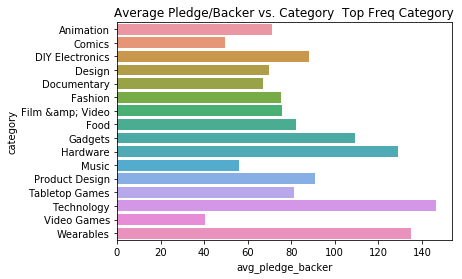

In [17]:
# plot Average pledge/backer against categories for high frequency categories
sns.barplot(x='avg_pledge_backer', y = 'category', 
            data=cat_groups_highval).set_title("Average Pledge/Backer vs. Category  Top Freq Category")

Top Avg. Pledge / Backer by Backer 


category  avg_pledge_backer  pledged_vgoal  value_count
41               Flight         287.927413      11.215962            6
91            Sculpture         281.684397      11.440762            4
103           Thrillers         220.627964       1.958722            2
0           3D Printing         216.639694      15.659178           23
47      Gaming Hardware         209.945873       7.878838            6
62          Mixed Media         202.962145      20.493231            5
13     Camera Equipment         196.251683      10.181887           26
87               Robots         170.822732      29.581179           18
100          Technology         146.360740      10.131374          152
95                Sound         146.322982       9.403172           26
8          Architecture         141.114245       3.283888            2
56   Interactive Design         137.706212       3.931860            2

Text(0.5, 1.0, 'Average Pledge/Backer vs. Category: ranked by Avg. PLedge')

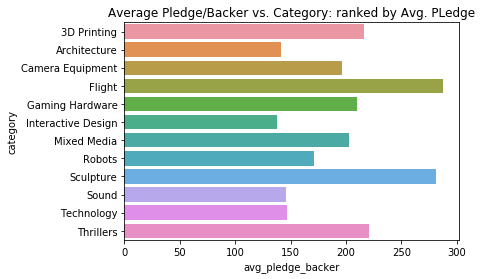

In [18]:
# Plot by top average pledge/backer fields 
    # isolate top average pledges by percentile 
tgt_perc = 90   # choose percentile 
percentile_val_avgpledge = np.percentile(cat_groups['avg_pledge_backer'], tgt_perc)
cat_groups_toppledge_backer = cat_groups[cat_groups['avg_pledge_backer']>=percentile_val_avgpledge] 
    # show table 
print("Top Avg. Pledge / Backer by Backer ")  
cat_groups_toppledge_backer.sort_values(by = ['avg_pledge_backer'], ascending=False)
sns.barplot(x = 'avg_pledge_backer', y='category', 
            data=cat_groups_toppledge_backer).set_title("Average Pledge/Backer vs. Category: ranked by Avg. PLedge")

Top Performance: Pledged / Backer


category  avg_pledge_backer  pledged_vgoal  value_count
84   Radio &amp; Podcasts          50.123652    2097.643040           11
51                Hip-Hop          45.606230     162.405903            5
46                  Games          78.204583     146.843614           37
42                   Food          82.160857     131.916562           46
107           Video Games          40.367670      82.172159          524
7                    Apps          39.043396      59.123833           17
85          Ready-to-wear          70.097185      49.702400            3
23              Cookbooks          41.104055      32.134043            7
87                 Robots         170.822732      29.581179           18
104            Typography          60.291638      21.316688            2
62            Mixed Media         202.962145      20.493231            5
99         Tabletop Games          81.041378      18.861807          742

Text(0.5, 1.0, 'Top Performance (Pledged / Goal)')

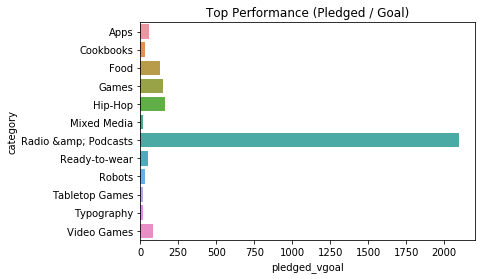

In [30]:
# Plot by performance fields (pledged / goal)
    # isolate top average pledges by percentile 
percentile_val_pledgedvgoal = np.percentile(cat_groups['pledged_vgoal'], tgt_perc)
cat_groups_pledgevgoal = cat_groups[cat_groups['pledged_vgoal']>=percentile_val_pledgedvgoal] 
    # show table 
print("Top Performance: Pledged / Backer")  
cat_groups_pledgevgoal.sort_values(by = ['pledged_vgoal'], ascending=False)
sns.barplot(x = 'pledged_vgoal', y='category', 
            data=cat_groups_pledgevgoal).set_title("Top Performance (Pledged / Goal)")
# sns.plt.title("Average Pledge/Backer vs. Category: ranked by Avg. PLedge")

In [21]:
# df_piv = pd.pivot_table(df2, index='category',values='amt.pledged')
df_piv = pd.pivot_table(df2, index='category',values='amt.pledged').reset_index()  
type(df_piv); df_piv.columns

pandas.core.frame.DataFrame

Index(['category', 'amt.pledged'], dtype='object')

In [24]:
# Function break lists into seperate lines 
def flat_len_list(df, list_column): 
    len_list = []
    for fld_row in range(df.shape[0]):
        rec = df[list_column][fld_row][1:-1]   # remove open/close brackets from list 
        rec_split = rec.split(',') 
        len_list.append(len(rec_split))
    return len_list 

def flatten_list_df(df, list_column): 
    t_list = []
    for fld_row in range(df.shape[0]):
        rec = df[list_column][fld_row][1:-1]   # remove open/close brackets from list 
        rec_split = rec.split(',') 
        for x in rec_split:
            t_list.append(x)
    return t_list 

flat_pledge = flatten_list_df(df2, "pledge.tier")
flat_backers = flatten_list_df(df2, "num.backers.tier")

In [25]:
# Function to flatten og dataset and add flat fields 
def expand_df_flatten(df, list_column, new_column):
    lens_of_lists = flat_len_list(df, list_column) 
    origin_rows = range(df.shape[0])   # range object for no. of rows: 4k rows 
    """ create array marking each digit with its row. 
    For instance first list (row zero) has 26 digits, 2nd list 75 digits. 3rd list has 457 digits 
    destination rows will have 26 0's, 75 1's, 457 2's.... 
    This will be used for number of row copies. 
    """
    destination_rows = np.repeat(origin_rows, lens_of_lists)
        # create DF excluding list column 
    non_list_cols = (
      [idx for idx, col in enumerate(df.columns)
       if col != list_column]
    )
    expanded_df = df.iloc[destination_rows, non_list_cols].copy()
    expanded_df[new_column] = flatten_list_df(df, list_column) 
    return expanded_df

In [26]:
# First flatten pledge tier then add flatted num of backers lists 
df2_exp = expand_df_flatten(df2, "pledge.tier", "pledge_tier2")
df2_exp['num_backers'] = flatten_list_df(df2, "num.backers.tier")
df2_exp.shape

(57996, 16)

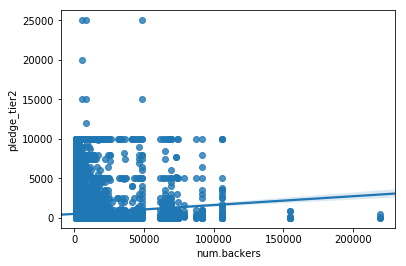

In [27]:
# Scatterplot of num_backers per pledge Tier 
df2_exp['pledge_tier2'] = pd.to_numeric(df2_exp['pledge_tier2'], errors='coerce')  # convert pledge_tiers to numbers 
sns.regplot(x=df2_exp['num.backers'], y=df2_exp['pledge_tier2'])

In [44]:
# WordCloud visualization function
def wordcloud_vis(text_array):
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black',
        stopwords = STOPWORDS).generate(str(text_array))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

WordCloud for Fashion Top Backers 


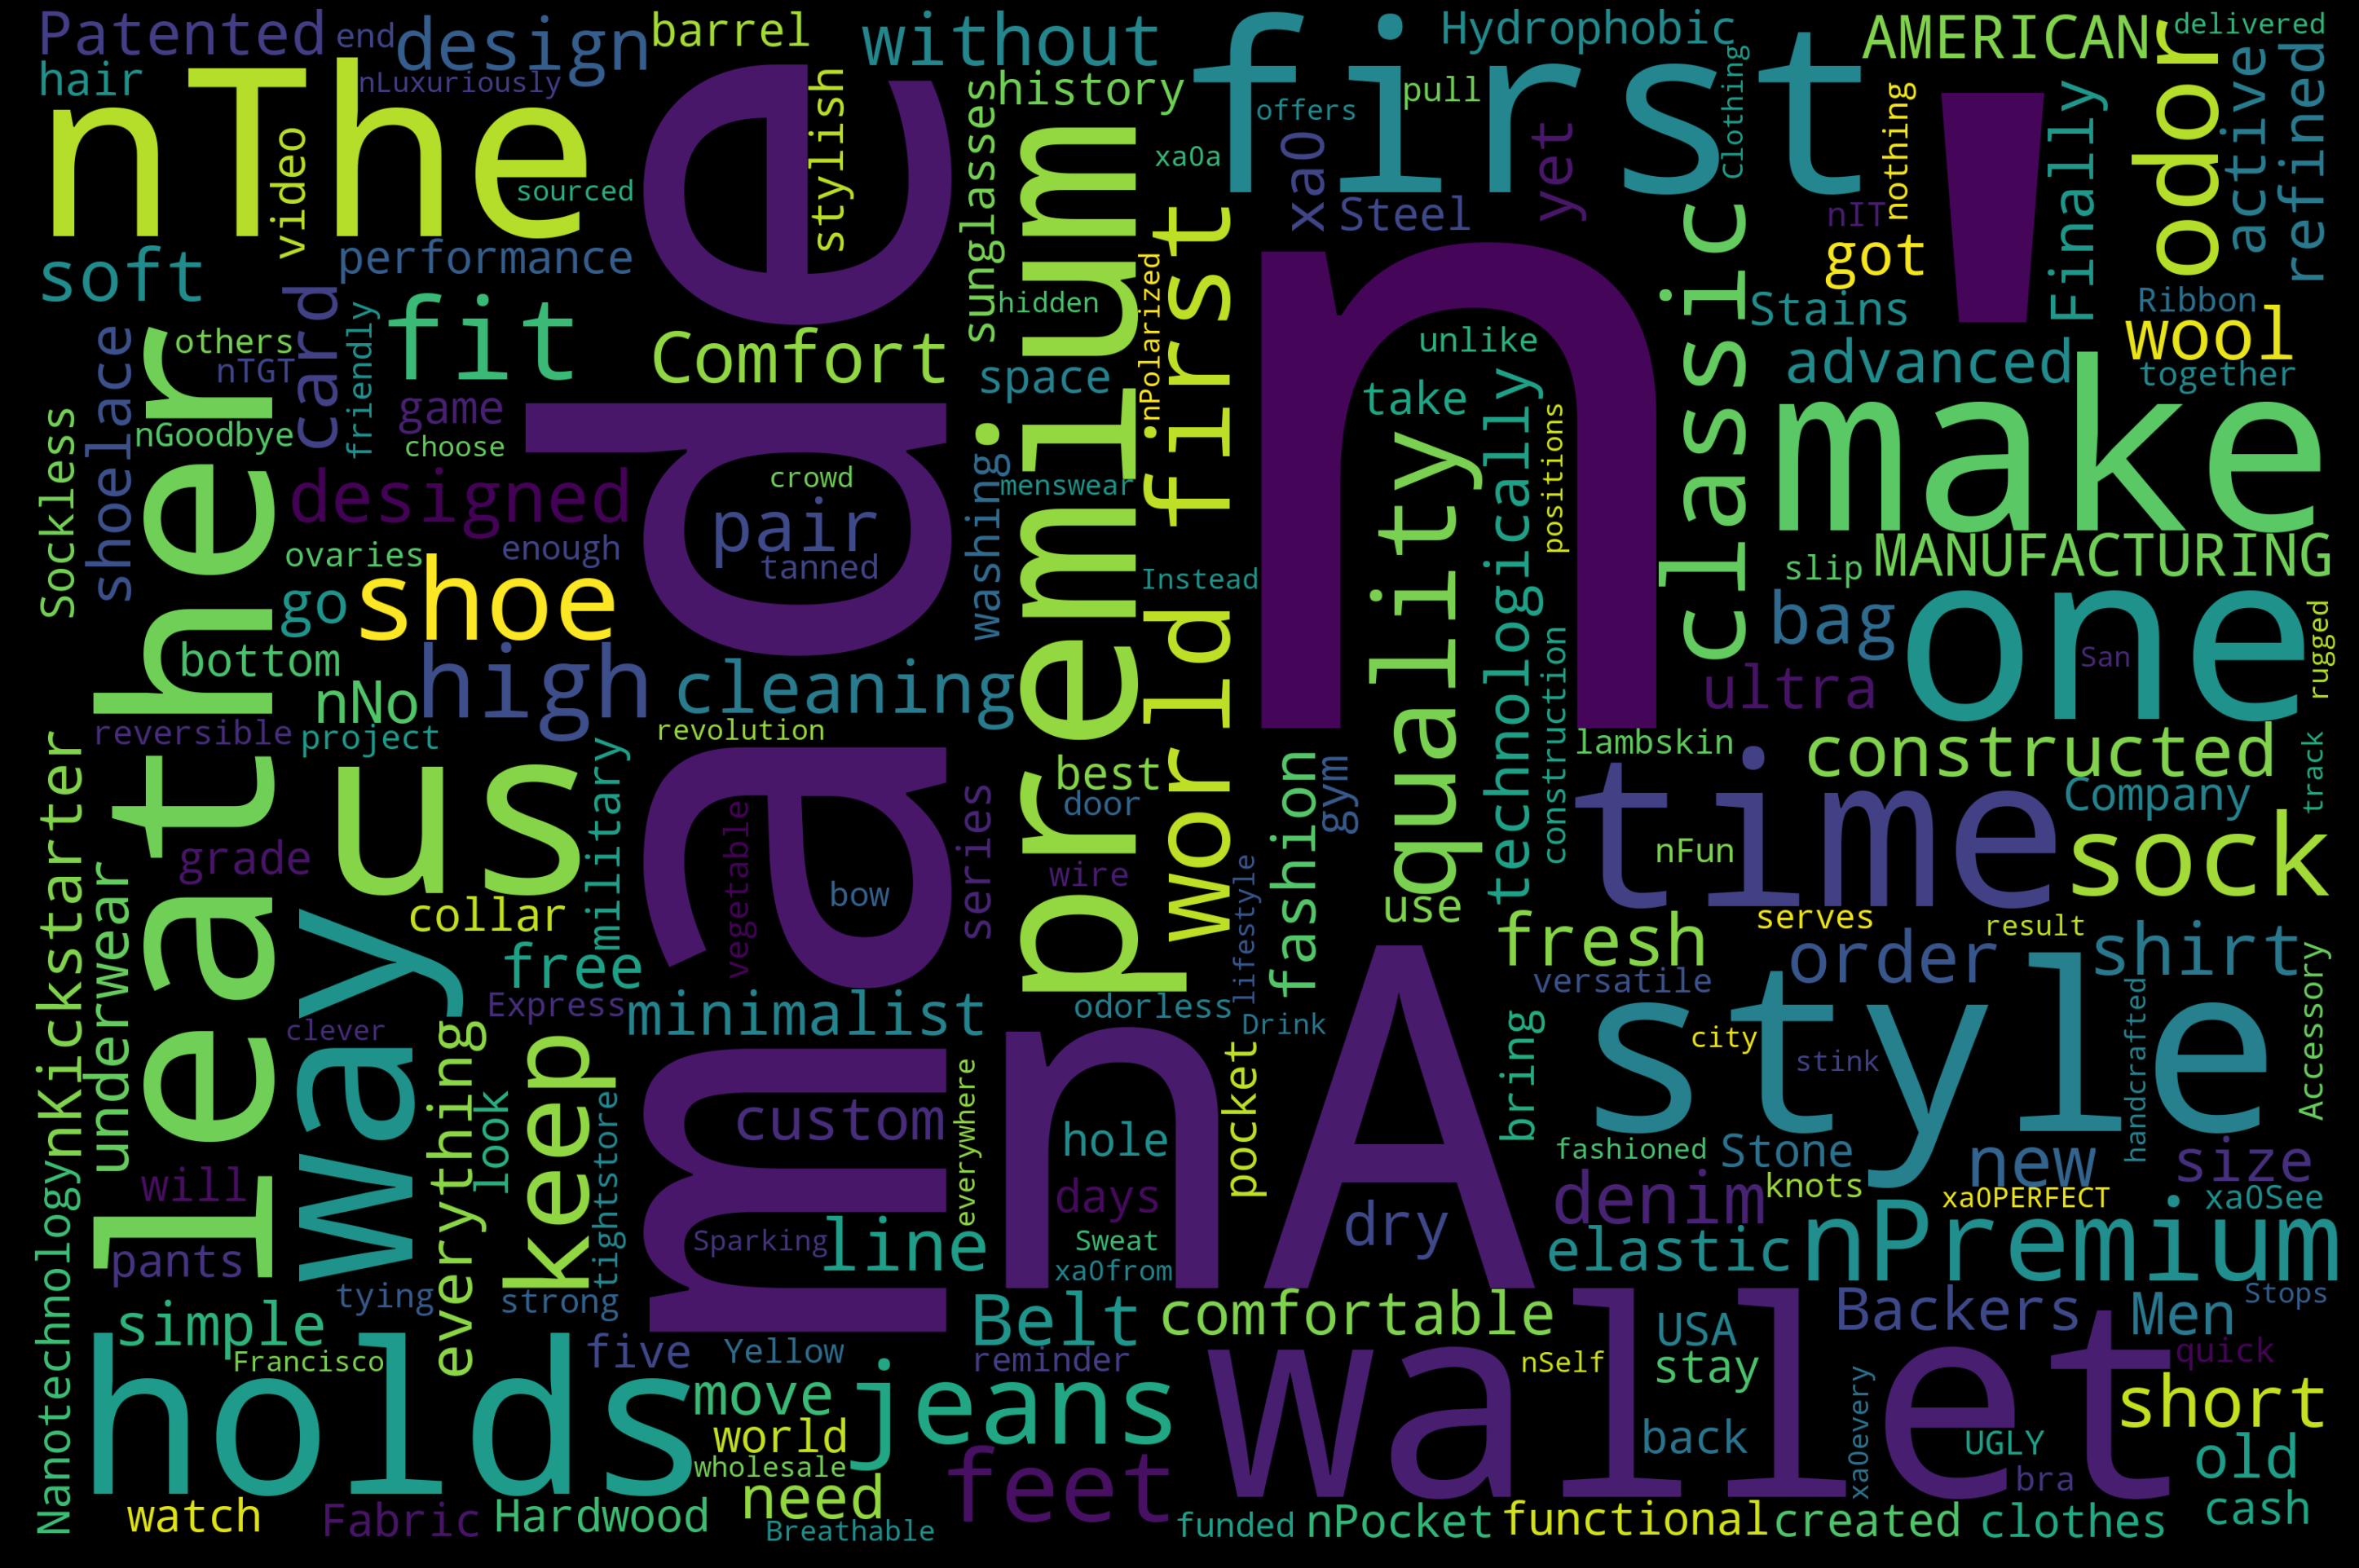

In [36]:
# WordCloud of top backers in Fashion only 
    # Blurbs for Fashion category
df_fashion = df2[df2.category=='Fashion']
text = df_fashion.blurb.values
print("WordCloud for Fashion Top Backers ")
wordcloud_vis(text)

Wordcloud on BLURB (High Average Backer): Number of projects 31


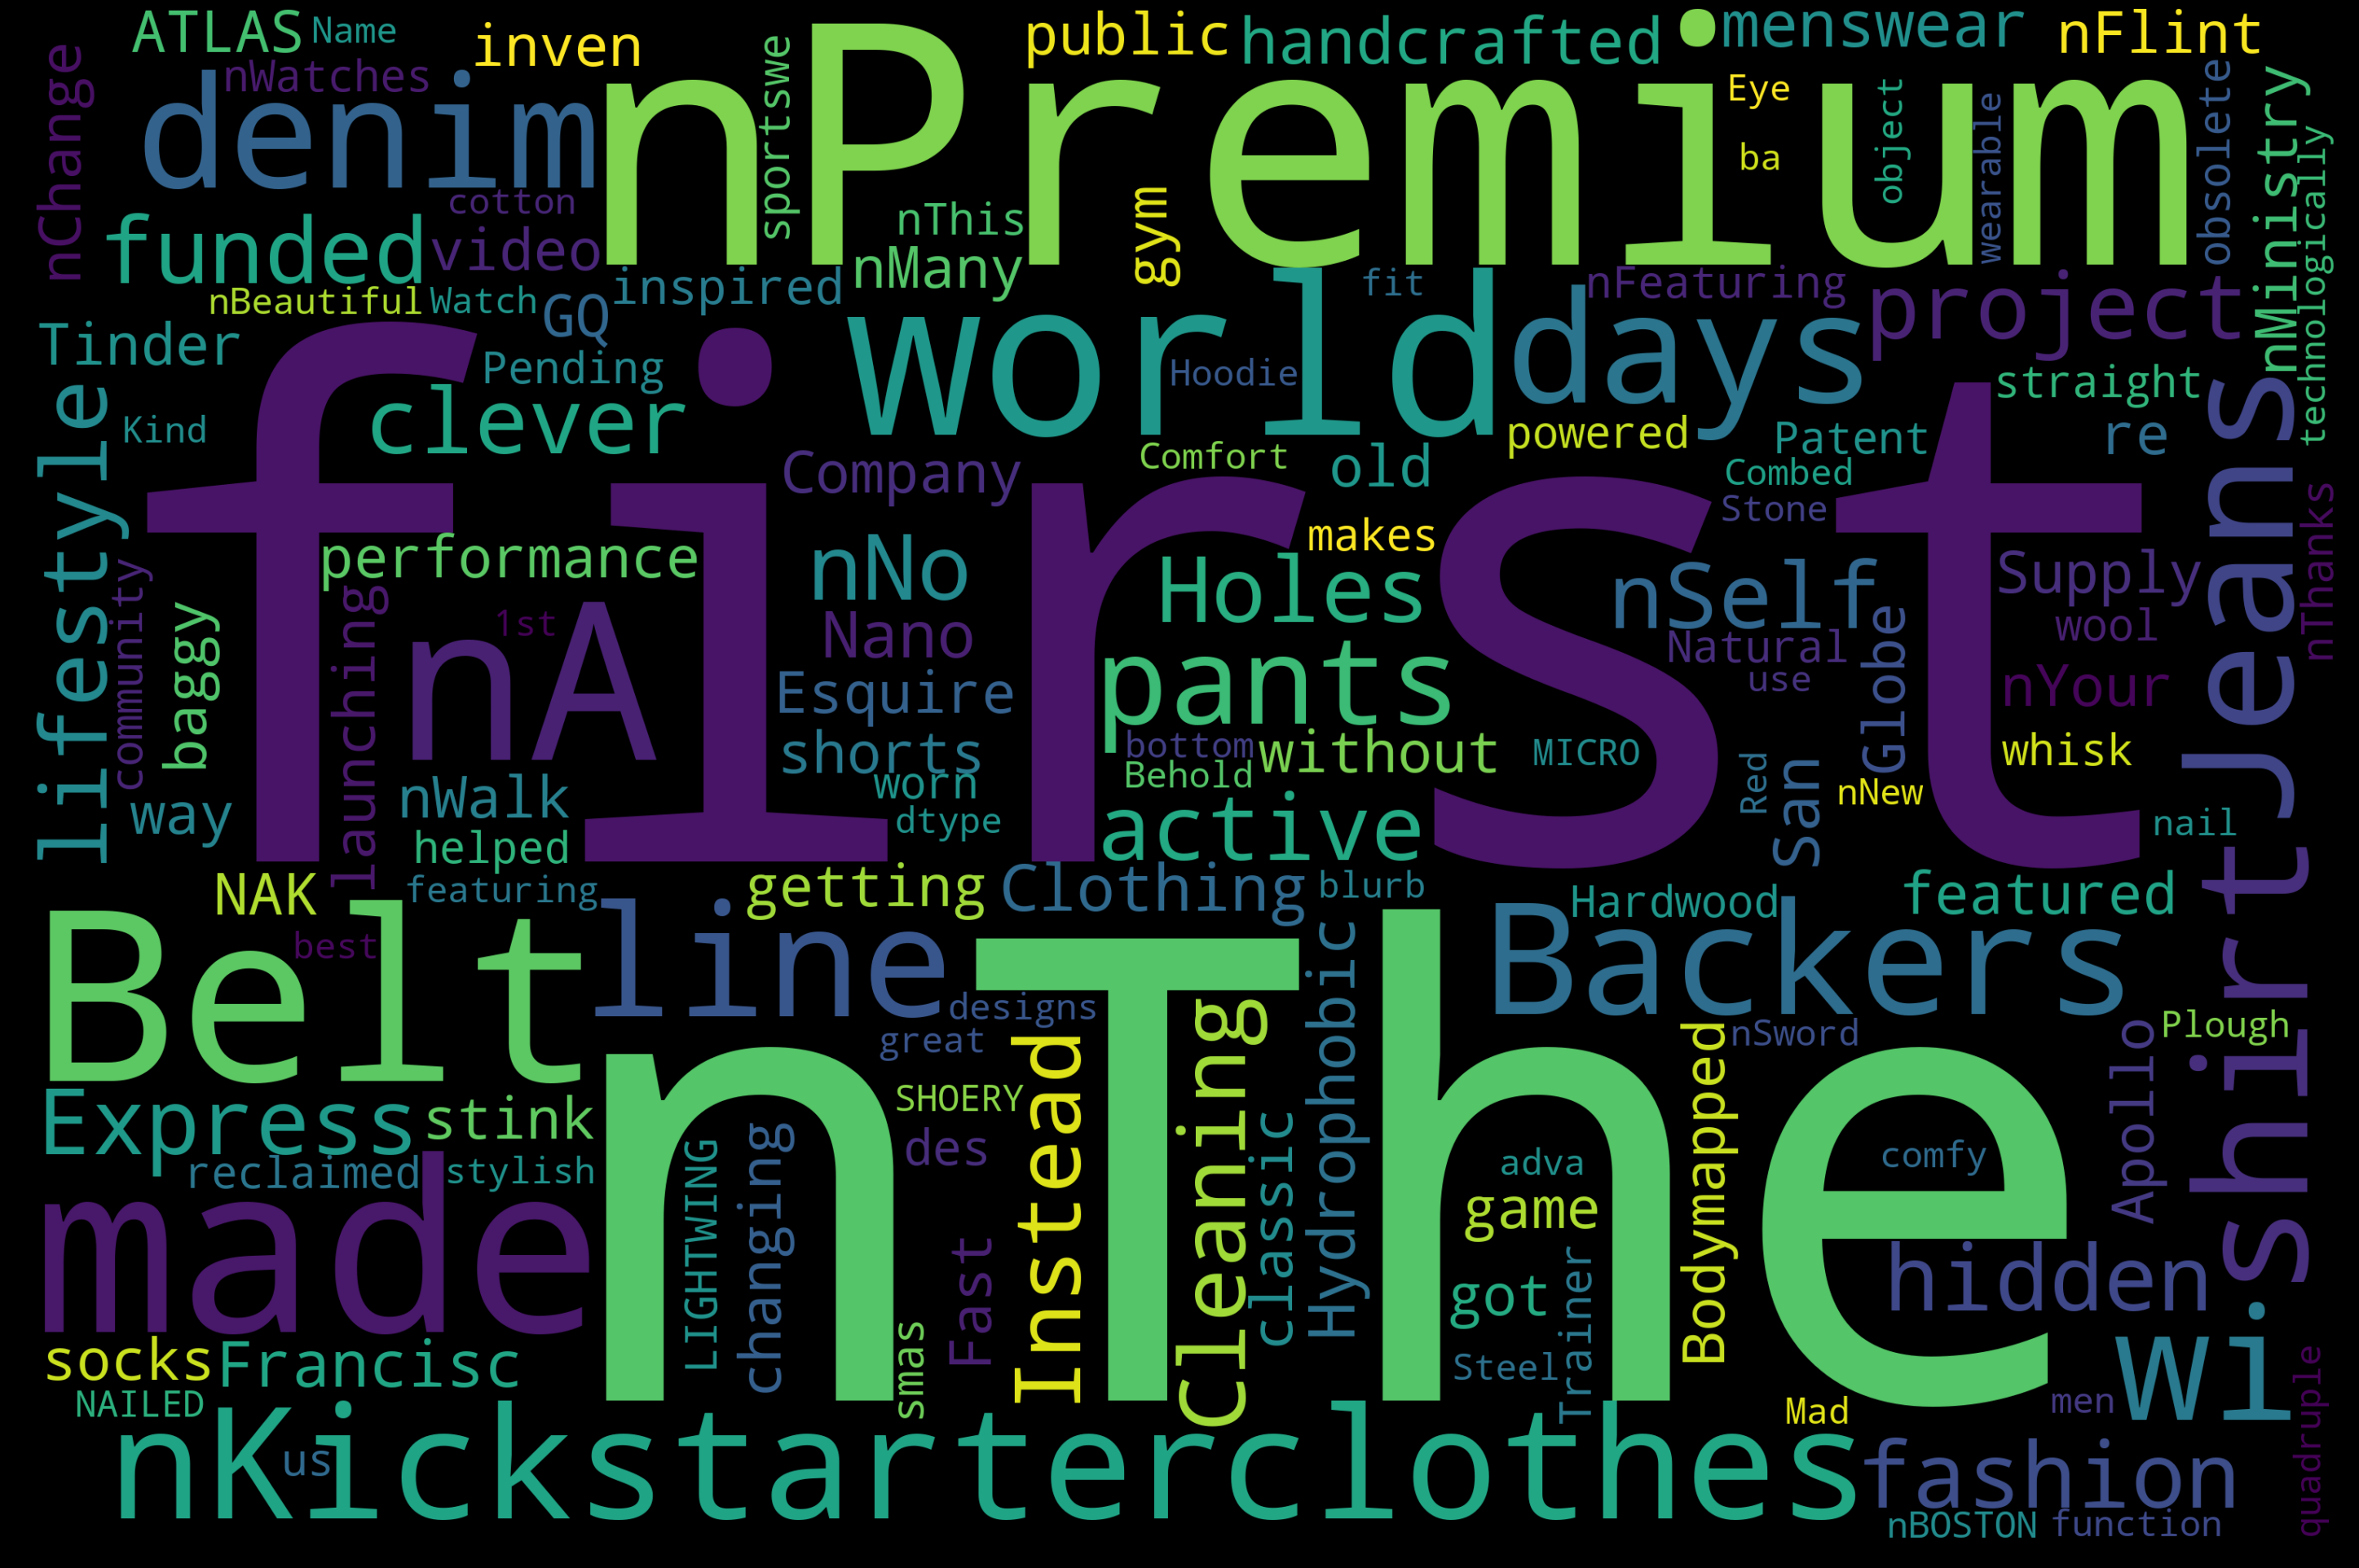

Wordcloud on TITLE (High Average Backer): Number of Projects 31


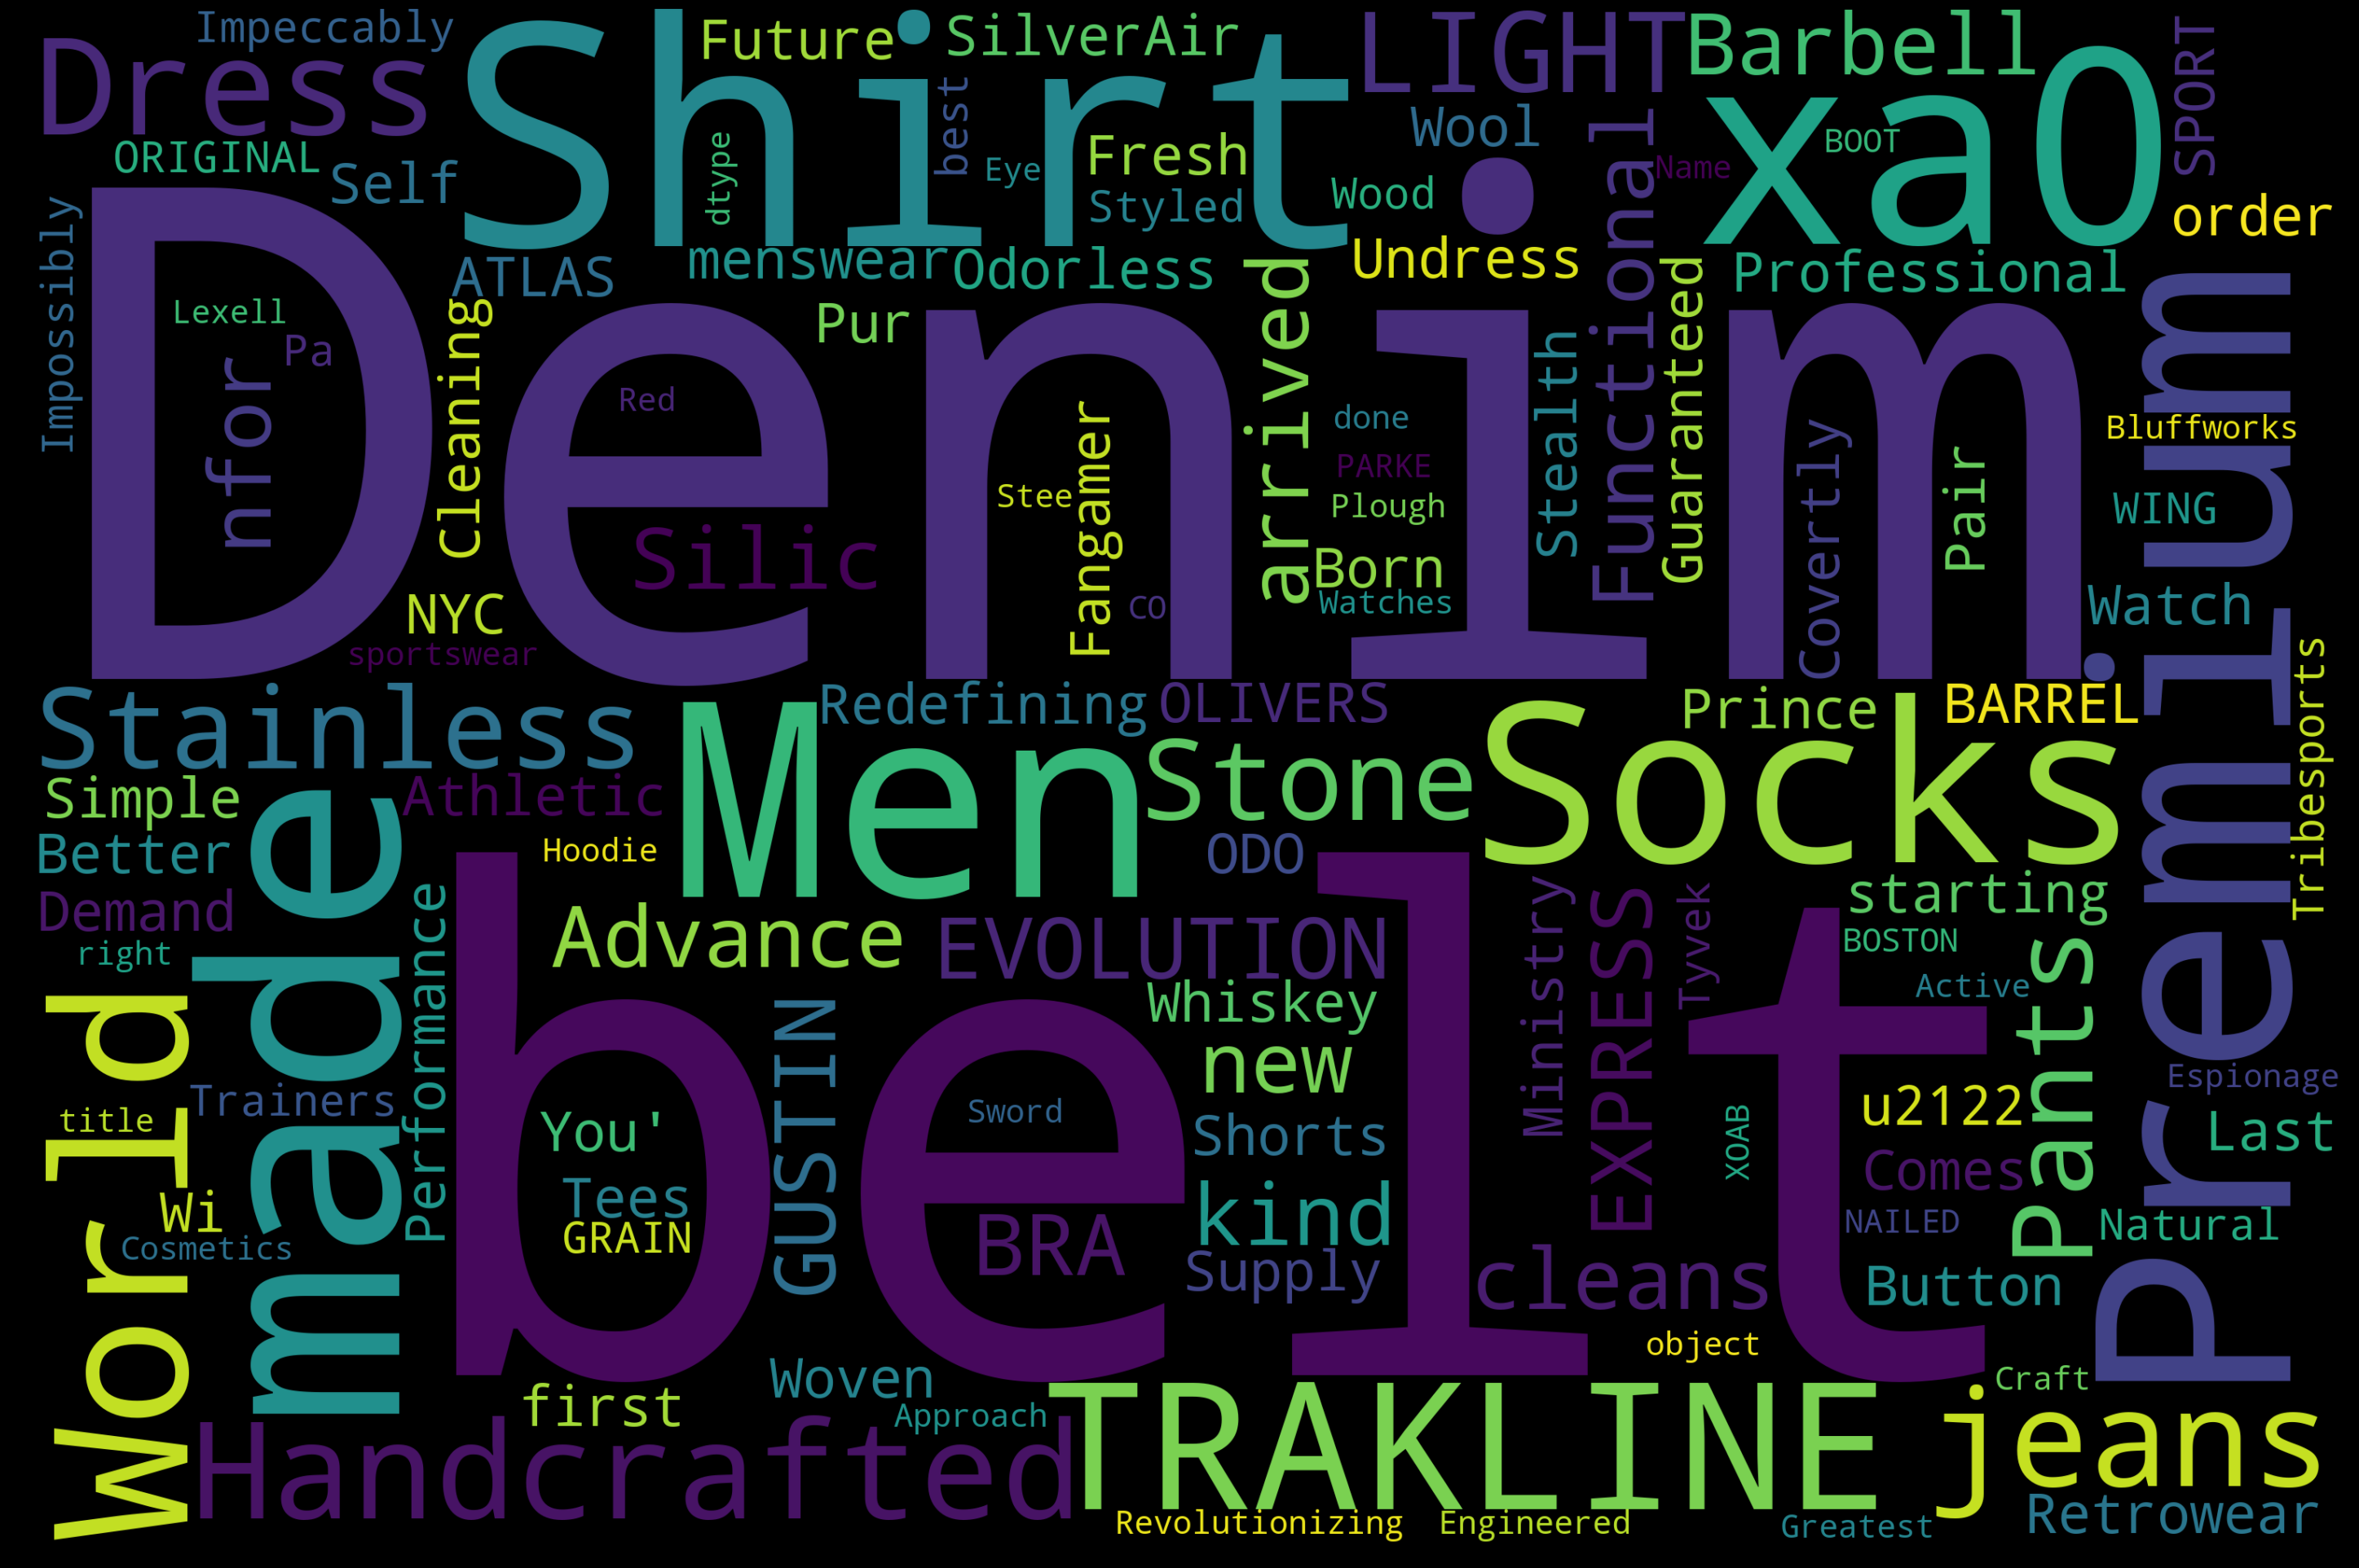

In [55]:
# WordCloud for Blurb: highest average pledge within Fashion
    # isolate top average / backer by percentile 
tgt_perc_fashion = 50
perc_avgback_fashion = np.percentile(df2.avg_pledge[df2.category=='Fashion'], tgt_perc_fashion)
text = df2.blurb[(df2.category=='Fashion') & (df2.avg_pledge>=perc_avgback_fashion)] 
print("Wordcloud on BLURB (High Average Backer): Number of projects", len(text) ) 
wordcloud_vis(text)

# Wordcloud for titiel: highest avg pledge within Fashion 
text = df2.title[(df2.category=='Fashion') & (df2.avg_pledge>=perc_avgback_fashion)]
print("Wordcloud on TITLE (High Average Backer): Number of Projects", len(text))
wordcloud_vis(text)

Wordcloud on Blurb (Highest Pledge / Goal): Number of projects 31


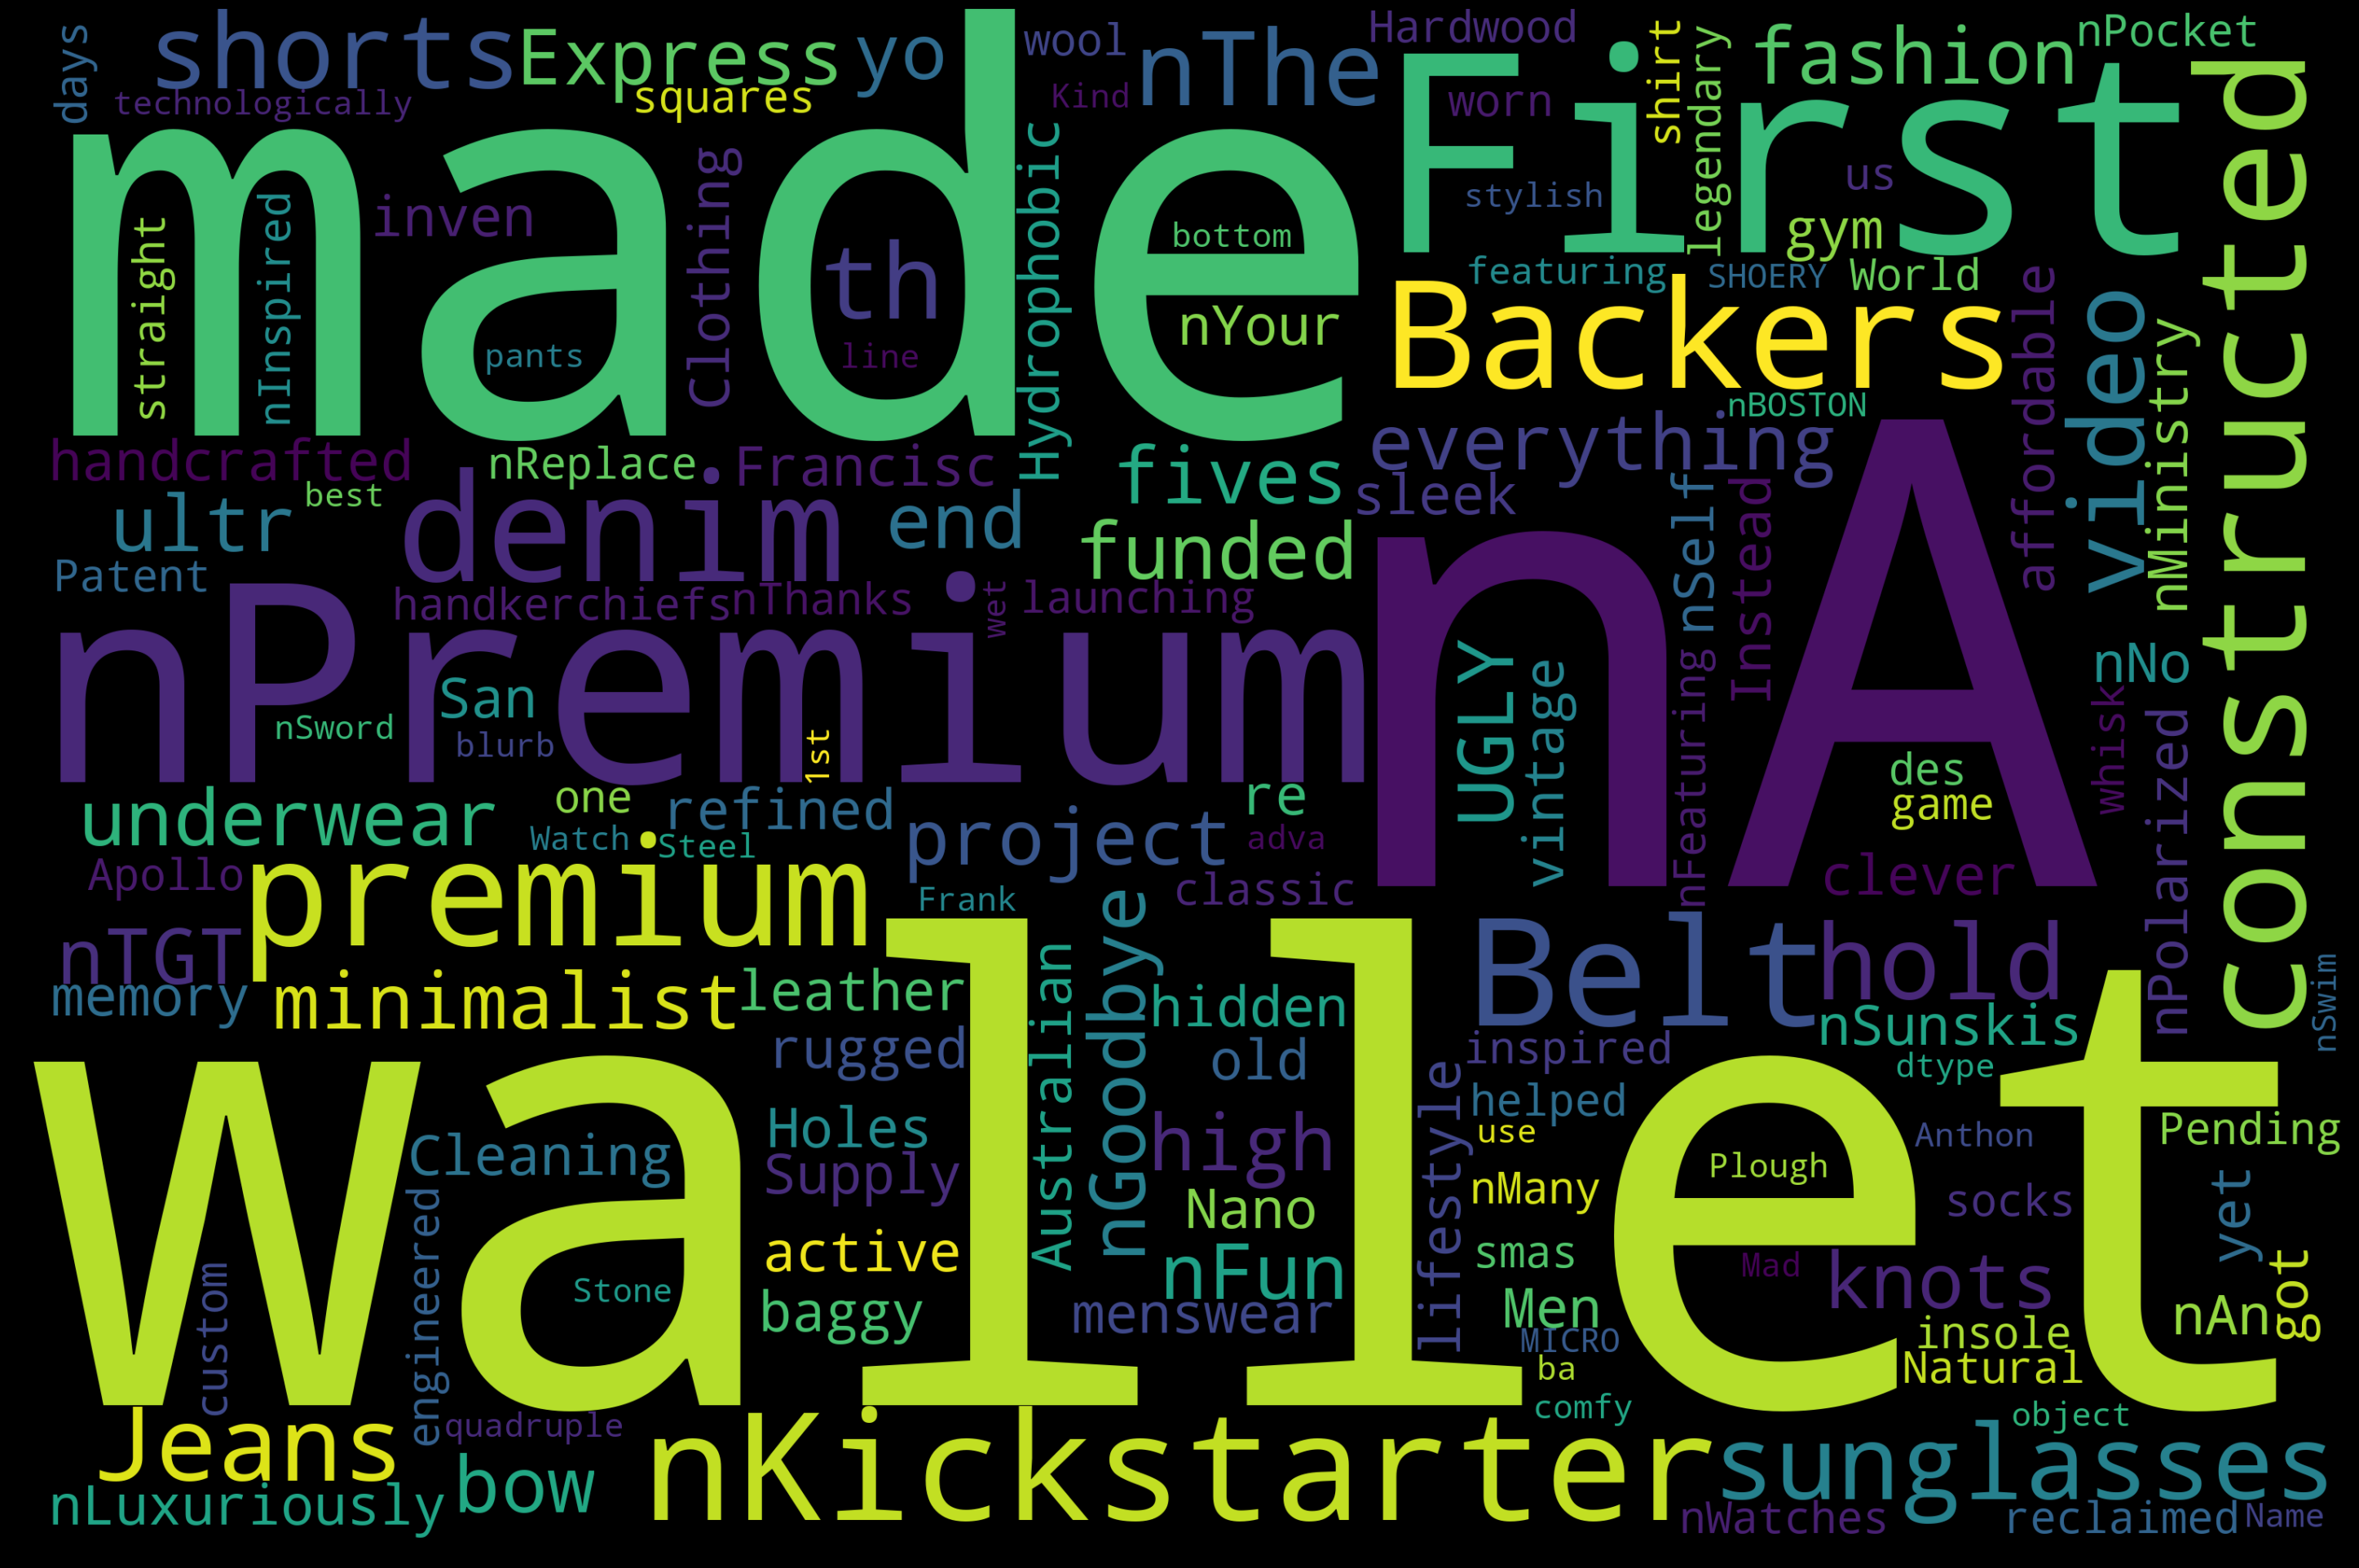

Wordcloud on Title (Highest Pledge / Goal): Number of projects 31


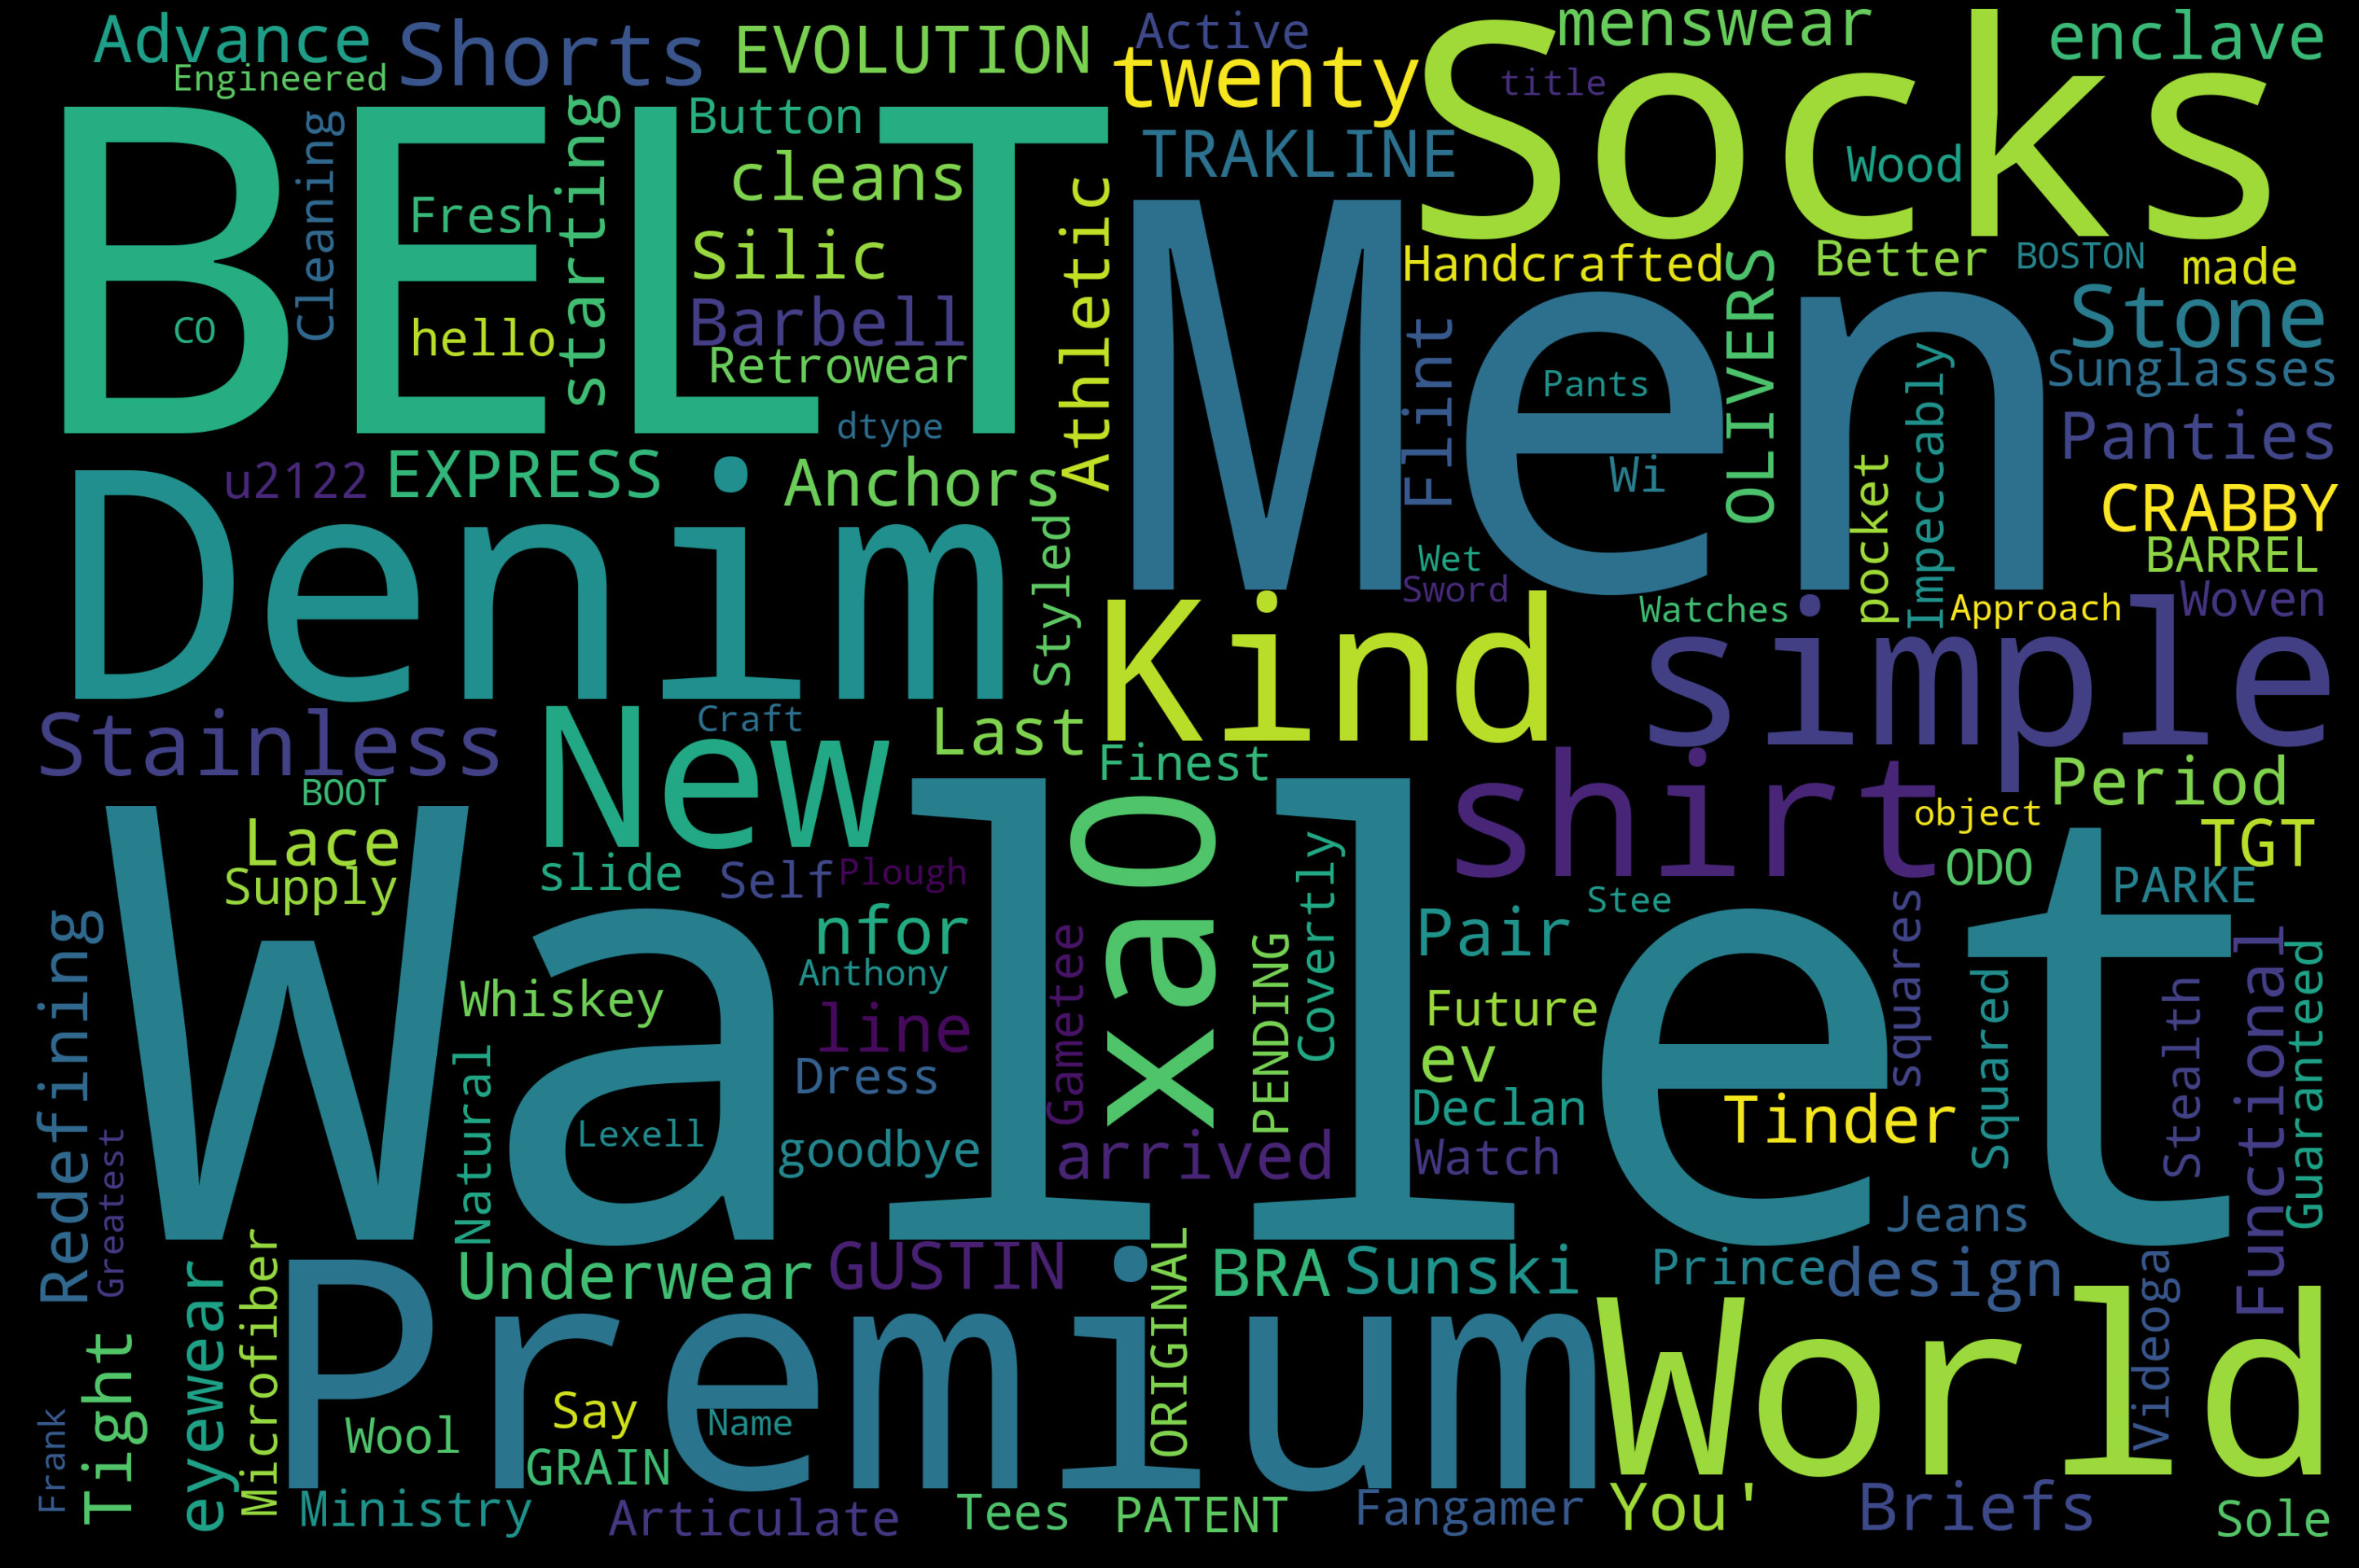

In [56]:
# WordCloud on Blurb: highest "Pledge over Goal" within Fashion
    # isolate top average / backer by percentile 
perc_pledgevgoal_fashion = np.percentile(df2.pledged_vgoal[df2.category=='Fashion'], tgt_perc_fashion)
text = df2.blurb[(df2.category=='Fashion') & (df2.pledged_vgoal>=perc_pledgevgoal_fashion)] 
print("Wordcloud on Blurb (Highest Pledge / Goal): Number of projects", len(text) )
wordcloud_vis(text)

# WordCloud on title: highest "Pledge over Goal" within Fashion 
text = df2.title[(df2.category=='Fashion') & (df2.pledged_vgoal>=perc_pledgevgoal_fashion)] 
print("Wordcloud on Title (Highest Pledge / Goal): Number of projects", len(text) )
wordcloud_vis(text)